In [1]:
import sounddevice as sd    # type: ignore
import numpy as np  # type: ignore
from tensorflow.keras.models import load_model # type: ignore
import pickle
from sklearn.preprocessing import LabelEncoder  # type: ignore
import librosa  # type: ignore
import librosa.display # type: ignore
import matplotlib.pyplot as plt     # type: ignore

In [2]:
#--------------------------------------------------------------------------
# Load CNN Model
print('-----------------------------------------')
print("#: load CNN model")
myModel = load_model('D:\\SF-67\\model\\20241130164341\\myModel.h5') 
myModel.summary()

# load config
print('-----------------------------------------')
print("#: load label config")

with open ('D:\\SF-67\\model\\20241130164341\\labels', 'rb') as fp:
    labels = pickle.load(fp)

print("labels : " + str(labels))
# Encode target labels
label_encoder = LabelEncoder()
label_encoder.fit_transform(labels)


-----------------------------------------
#: load CNN model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 170, 128)     1280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 85, 128)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 83, 128)      147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 41, 128)       0         
_________________________________________________________________
dense_5 (Dense)              (None, 62, 41, 64)        8256      
_________________________________________________________________
dense_6 (Dense)              (None, 62, 41, 32)        2080      
____________________________________________________________

array([0, 1], dtype=int64)

In [3]:
from scipy.fft import fft, fftfreq # type: ignore
samplerate = 22050  # Whisper expects 16kHz audio
chunk_duration = 1  # Duration of each audio chunk in seconds

# ----- 1-D discrete Fourier transforms ------
def audioFFT_cal (data):
    N = int (chunk_duration * samplerate)        #   Number of sample points

    T = 1.0 / (samplerate)   # sample spacing
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = fft(data)
    Xf = fftfreq(N, T)[:N//2]
    FFT_Amplitude = 10*np.log(np.abs(yf[0:N//2]))
    
    return Xf,FFT_Amplitude

#--------------------------------------------------------------------------
def extract_mel_spectrogram(audio):
     #### Converts audio signal to a mel spectrogram. ####
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=samplerate, n_fft=2048, hop_length=128, n_mels=256)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
   # print(f'Shape of spectrogram : {mel_spectrogram_db.shape }')
    return mel_spectrogram_db

def predict_audio_class(audio_frame):
    #### Predicts the class of an audio frame. ####
    mel_spectrogram = extract_mel_spectrogram(audio_frame) / 255.0
    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=0)  # Add batch dimension
    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=-1)  # Add channel dimension

    PredictionProb = myModel.predict(mel_spectrogram)
    predicted_class = np.argmax(PredictionProb, axis=1)
    return PredictionProb,predicted_class


In [4]:

def initGraph(y_signal):
    global TimeDomainGraph, FrqeDomainGraph ,SpectrogramGraph, Maintitle, figure

    plt.ion()  # turning interactive mode on
    
    figure = plt.figure(figsize=(10, 8))
    figure.suptitle(f'Prediction Output : -',fontweight="bold", size=20)

    gs = figure.add_gridspec(2,2)
    ax1 = figure.add_subplot(gs[0, 0])
    ax2 = figure.add_subplot(gs[0, 1])
    ax3 = figure.add_subplot(gs[1, :])

    #figure, ax = plt.subplots(2,2,figsize=(10, 8),squeeze=False)
    
    # ----- Plot Audio Waveform  -----
    audioTimespace = np.linspace(0, len(y_signal) / samplerate, len(y_signal))
    ax1.title.set_text('Audio Waveform')
    ax1.set_ylabel('Normalize Amplitude')
    ax1.set_xlabel('Time (s)')
    ax1.grid()
    TimeDomainGraph, = ax1.plot(audioTimespace, y_signal)

    # ----- Plot FFT  -----
    xf,yf = audioFFT_cal(y_signal)   
    ax2.title.set_text('FFT waveform')
    ax2.set_ylabel('Normalize Amplitude (dB)')
    ax2.set_xlabel('Freq (Hz)')
    ax2.grid()
    ax2.set_ylim(-70,80)
    FrqeDomainGraph, = ax2.plot(xf, yf)

    # ------- Plot Spectrogram ---------
    spectrogram_db = extract_mel_spectrogram(y_signal)
    ax3.title.set_text(f'Spectrogram shape {spectrogram_db.shape}')
    ax3.set_ylabel('Frequency (Hz)')
    ax3.set_xlabel('Time (s)')
    ax3.grid()
    SpectrogramGraph = ax3.imshow(spectrogram_db,interpolation='nearest', aspect='auto')
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])


In [5]:
def UpdatGraph(y_signal,title):
    # plotting newer graph
    TimeDomainGraph.set_ydata(y_signal)

    xf,yf = audioFFT_cal(y_signal) 
    FrqeDomainGraph.set_xdata(xf)
    FrqeDomainGraph.set_ydata(yf)

    spectrogram_db = extract_mel_spectrogram(y_signal)
    SpectrogramGraph.set_data(spectrogram_db)

    figure.suptitle(f'Prediction Output : {str(title[0])}',fontweight="bold", size=20)

    figure.canvas.draw()
    figure.canvas.flush_events()
    # plt.pause(0.01)


Predicted Prob: [[5.7891586e-34 1.0000000e+00]]
Predicted Class: [1]
Predicted Lable: ['No_Drone']



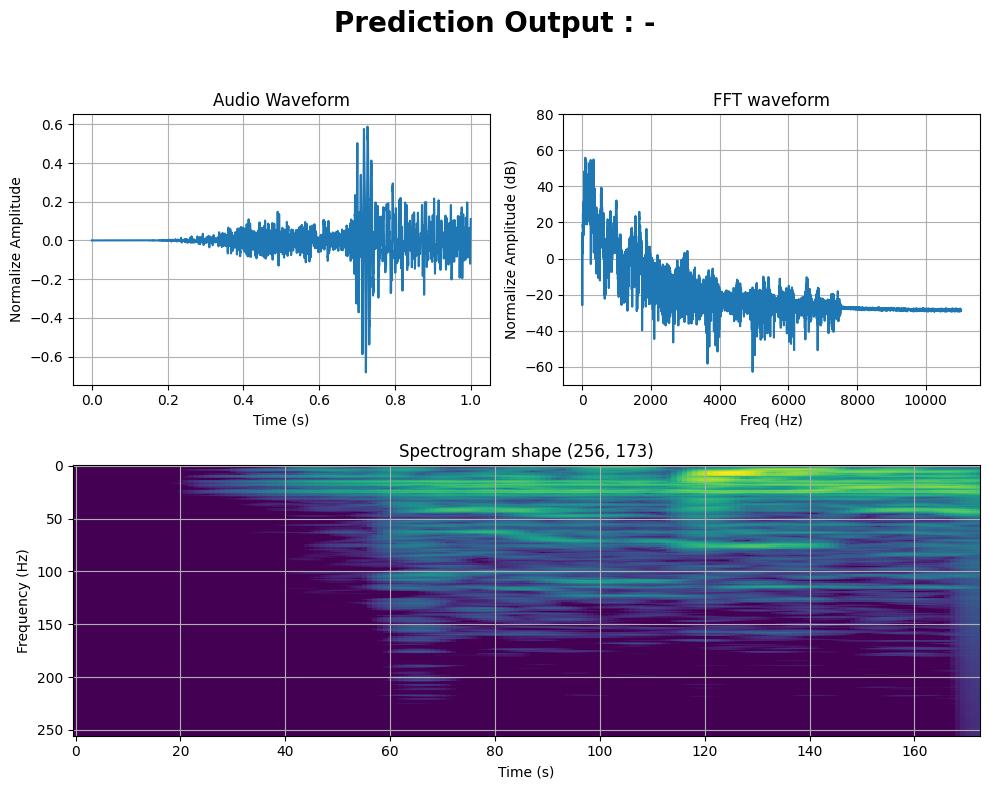

In [6]:
audio_buffer = []
chunk = sd.rec(int(samplerate * chunk_duration), samplerate=samplerate, channels=1, dtype='float32')
sd.wait()  
audio_buffer = np.squeeze(chunk)
PredictionProb,class_prediction = predict_audio_class(audio_buffer)
lable_Output = label_encoder.inverse_transform(class_prediction)
print(f"Predicted Prob: {PredictionProb}")
print(f"Predicted Class: {class_prediction}")
print(f'Predicted Lable: {lable_Output}')
print()
initGraph(audio_buffer)

In [23]:
import pyaudio      # type: ignore

FRAMES_PER_BUFFER  = 1000
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 22050
RECORD_SECONDS = 1

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=FRAMES_PER_BUFFER )

frames = []
for i in range(0, int((RATE / FRAMES_PER_BUFFER ) * RECORD_SECONDS)):
    data = stream.read(FRAMES_PER_BUFFER )
    frames.append(data)

stream.stop_stream()
stream.close()
p.terminate()

#audio_buffer = []
#audio_buffer = np.frombuffer(b''.join(frames), dtype=np.float32)
#initGraph(audio_buffer)

In [22]:
pyaudio_buffer = np.frombuffer(b''.join(frames), dtype=np.float32)
print(type(pyaudio_buffer))
print(type(pyaudio_buffer[0]))
print(pyaudio_buffer.shape)
print(pyaudio_buffer)
print(pyaudio_buffer[0])

PredictionProb,class_prediction = predict_audio_class(pyaudio_buffer)
lable_Output = label_encoder.inverse_transform(class_prediction)
print(f"Predicted Prob: {PredictionProb}")
print(f"Predicted Class: {class_prediction}")
print(f'Predicted Lable: {lable_Output}')
print()

initGraph(pyaudio_buffer)

<class 'numpy.ndarray'>
<class 'numpy.float32'>
(21504,)
[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  4.9468994e-02
  5.9539795e-02  6.9030762e-02]
0.0


InvalidArgumentError:  Input to reshape is a tensor with 39680 values, but the requested shape requires a multiple of 40672
	 [[node sequential_1/flatten_1/Reshape (defined at C:\Users\panya\AppData\Local\Temp\ipykernel_34428\312758913.py:31) ]] [Op:__inference_predict_function_1438]

Function call stack:
predict_function


<class 'numpy.ndarray'>
<class 'numpy.float32'>
(22050,)
[ 0.00000000e+00  0.00000000e+00 -3.05175781e-05 ...  9.35058594e-02
  1.01623535e-01  1.10046387e-01]
0.0
Predicted Prob: [[5.7891586e-34 1.0000000e+00]]
Predicted Class: [1]
Predicted Lable: ['No_Drone']



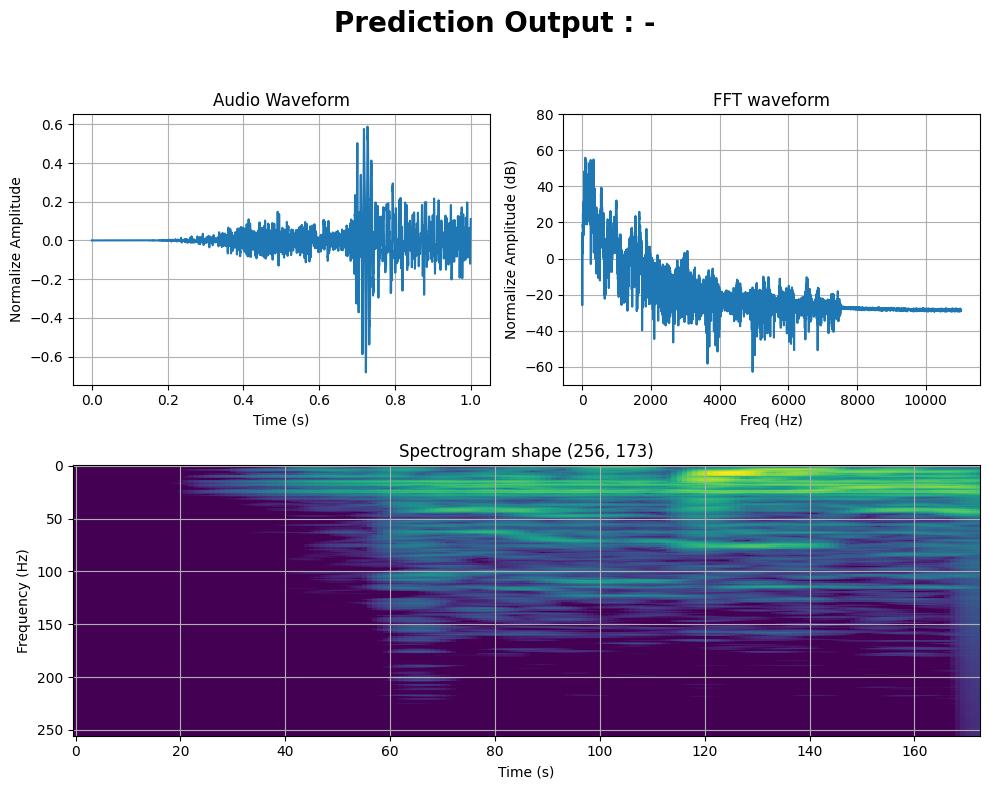

In [11]:
print(type(audio_buffer))
print(type(audio_buffer[0]))
print(audio_buffer.shape)
print(audio_buffer)
print(audio_buffer[0])

PredictionProb,class_prediction = predict_audio_class(audio_buffer)
lable_Output = label_encoder.inverse_transform(class_prediction)
print(f"Predicted Prob: {PredictionProb}")
print(f"Predicted Class: {class_prediction}")
print(f'Predicted Lable: {lable_Output}')
print()

initGraph(audio_buffer)